# Decision Tree



In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Xe", "Cs", "Ba", "La", "Ce",
    "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir",
    "Pt", "Au", "Hg", "Tl", "Pb", "Bi", "Po", "At", "Rn", "Fr", "Ra", "Ac", "Th", "Pa", "U", "Np", "Pu", "Am", "Cm",
    "Bk", "Cf", "Es", "Fm", "Md", "No", "Lr", "Rf", "Db", "Sg", "Bh", "Hs", "Mt", "Ds", "Rg", "Cn", "Nh", "Fl", "Mc",
    "Lv", "Ts", "Og"
}

# Load the data
with open('allData_result.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    # Set each element to 1 if it is present and it's a valid element, otherwise skip it
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()  # Features
y = df.copy()  # Multi-label targets, each element is its own label

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-1 | Actual: Fe, Mn, Co, Cr, Si, Cu | Predicted: Fe, Mn, Co, Cr, Si, Cu
paper-26 | Actual: Fe, Mn, Co, Cr, Ni | Predicted: Fe, Mn, Co, Cr, Ni
paper-7 | Actual: Fe, Co, Cr, Ni, Al, Ti | Predicted: Fe, Co, Cr, Ni, Al, Ti
paper-27 | Actual: Fe, Mn, Co, Cr, Ni | Predicted: Fe, Mn, Co, Cr, Ni
paper-31 | Actual: Fe, Mn, Co, Cr, Si, H | Predicted: Fe, Mn, Co, Cr, Cu, H, Zn
paper-138 | Actual: Fe, Cr, Cu, Al, Ti | Predicted: Co, Cr, Si, Al, Ti

Accuracy for Fold 1: 66.67%

Classification Report for Fold:
              precision    recall  f1-score   support

          Fe       1.00      0.83      0.91         6
          Mn       1.00      1.00      1.00         4
          Co       0.83      1.00      0.91         5
          Cr       1.00      1.00      1.00         6
          Si       0.50      0.50      0.50         2
          Cu       0.50      0.50      0.50         2
         

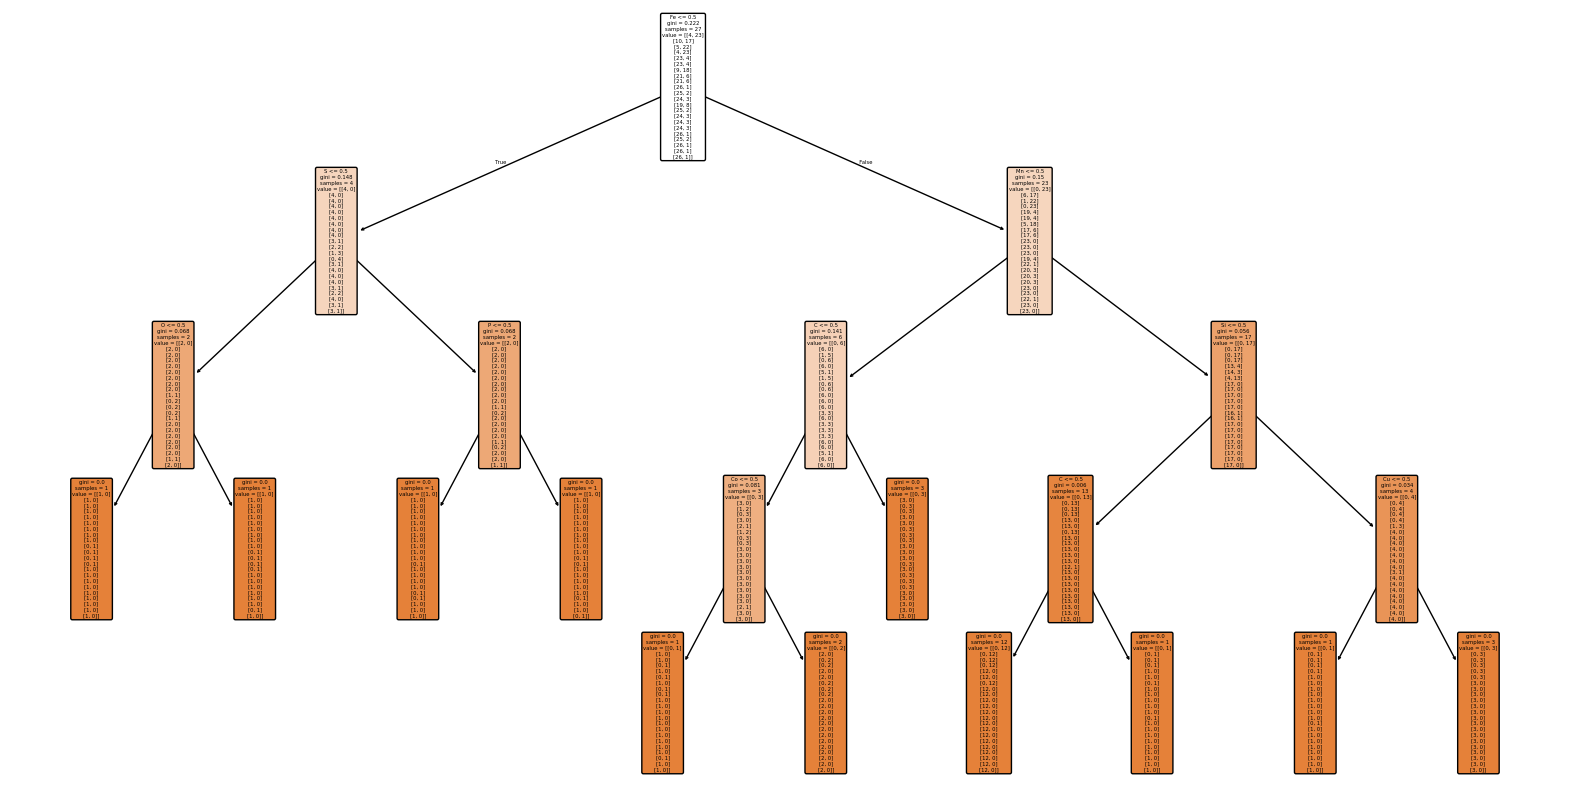

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Initialize the Decision Tree classifier with parameters
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can adjust `max_depth` as needed

# Fit the Decision Tree model using the entire dataset for visualization purposes
decision_tree.fit(X, y)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(decision_tree, feature_names=X.columns, class_names=[str(i) for i in y.columns], filled=True, rounded=True)
plt.show()


In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Initialize the Decision Tree classifier with parameters
decision_tree = DecisionTreeClassifier(random_state=42, max_depth=5)  # You can adjust `max_depth` as needed

# Fit the Decision Tree model using the entire dataset
decision_tree.fit(X, y)

# Export the decision tree to Graphviz format
dot_data = export_graphviz(decision_tree, out_file=None,
                           feature_names=X.columns,
                           class_names=[str(i) for i in y.columns],
                           filled=True, rounded=True, special_characters=True)

# Generate the graph using pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)

# Save the decision tree to a PDF file
output_path = "decision_tree.pdf"
graph.write_pdf(output_path)

print(f"Decision tree saved as PDF: {output_path}")



Decision tree saved as PDF: decision_tree.pdf


## Filter elements

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}



# Load the data
with open('allData_result.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    # Set each element to 1 if it is present and it's a valid element, otherwise skip it
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()  # Features
y = df.copy()  # Multi-label targets, each element is its own label

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-1 | Actual: Fe, Mn, Co, Cr, Si, Cu | Predicted: Fe, Mn, Co, Cr, Si, Cu
paper-26 | Actual: Fe, Mn, Co, Cr, Ni | Predicted: Fe, Mn, Co, Cr, Ni
paper-7 | Actual: Fe, Co, Cr, Ni, Al, Ti | Predicted: Fe, Co, Cr, Ni, Al, Ti
paper-27 | Actual: Fe, Mn, Co, Cr, Ni | Predicted: Fe, Mn, Co, Cr, Ni
paper-31 | Actual: Fe, Mn, Co, Cr, Si, H | Predicted: Fe, Mn, Co, Cr, Zn
paper-138 | Actual: Fe, Cr, Cu, Al, Ti | Predicted: Cr, Si, Cu, Al, Ti

Accuracy for Fold 1: 66.67%

Classification Report for Fold:
              precision    recall  f1-score   support

          Fe       1.00      0.83      0.91         6
          Mn       1.00      1.00      1.00         4
          Co       1.00      1.00      1.00         5
          Cr       1.00      1.00      1.00         6
          Si       0.50      0.50      0.50         2
          Cu       1.00      1.00      1.00         2
          Ni    

# New data

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('allData_result.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    # Check if 'composition' exists and is not None
    if not entry.get('composition'):
        # print(f"Skipping entry with title '{entry.get('title', 'Unknown Title')}' due to missing 'composition'")
        continue
    # Set each element to 1 if it is present and it's a valid element, otherwise skip it
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()  # Features
y = df.copy()  # Multi-label targets, each element is its own label

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-137 | Actual: Ti, Zr, Hf, Nb, Ta, Al | Predicted: Ti, Zr, Hf, Nb, Ta, Al
paper-130 | Actual: Ti, Zr, Nb, Ta | Predicted: Ti, Zr, Nb, Ta
paper-171 | Actual: N, I | Predicted: N, I
paper-161 | Actual: F, C, I, B, Y | Predicted: F, C, I, B, Y
paper-1 | Actual: Co, Cr, Fe, Mn, Cu, Si | Predicted: Co, Cr, Fe, Mn, Cu, Si
paper-33 | Actual: Co, Cr, Fe, Ni, Ti, Nb, Mo, Al, W, C | Predicted: Co, Cr, Fe, Ni, Ti, Nb, Mo, Al, W, C
paper-129 | Actual: Ti, Zr, Nb, Ta | Predicted: Ti, Zr, Nb, Ta
paper-134 | Actual: Co, Cr, Fe, Ni, Ti, Al | Predicted: Co, Cr, Fe, Ni, Ti, Al

Accuracy for Fold 1: 100.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         4
          Cr       1.00      1.00      1.00         4
          Fe       1.00    

# 02/04/2025

In [1]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    # Check if 'composition' exists and is not None
    if not entry.get('composition'):
        # print(f"Skipping entry with title '{entry.get('title', 'Unknown Title')}' due to missing 'composition'")
        continue
    # Set each element to 1 if it is present and it's a valid element, otherwise skip it
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()  # Features
y = df.copy()  # Multi-label targets, each element is its own label

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Loop over each fold
for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-1 | Actual: Co, Cr, Fe, Mn, Cu, Si | Predicted: Co, Cr, Fe, Mn, Cu, Si
paper-110 | Actual: Al, Si, Mg | Predicted: Al, Si, Mg
paper-131 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-144 | Actual: Ti, Zr, Hf, Ta, Mo, N | Predicted: Ti, Zr, Hf, Ta, Mo, N
paper-210 | Actual: Nb, Ta, Mo, C, W | Predicted: Nb, Ta, Mo, C, W
paper-218 | Actual: Co, Cr, Fe, Ni, Al, Cu | Predicted: Co, Cr, Fe, Ni, Al, Cu
paper-229 | Actual: Ti, Zr, V, Nb, Al | Predicted: Ti, Zr, V, Nb, Al

Accuracy for Fold 1: 100.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         6
          Cr   


============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-1 | Actual: Co, Cr, Fe, Mn, Cu, Si | Predicted: Co, Cr, Fe, Mn, Cu, Si
paper-110 | Actual: Al, Si, Mg | Predicted: Al, Si, Mg
paper-131 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-144 | Actual: Ti, Zr, Hf, Ta, Mo, N | Predicted: Ti, Zr, Hf, Ta, Mo, N
paper-210 | Actual: Nb, Ta, Mo, C, W | Predicted: Nb, Ta, Mo, C, W
paper-218 | Actual: Co, Cr, Fe, Ni, Al, Cu | Predicted: Co, Cr, Fe, Ni, Al, Cu
paper-229 | Actual: Ti, Zr, V, Nb, Al | Predicted: Ti, Zr, V, Nb, Al

Accuracy for Fold 1: 100.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         6
          Cr   

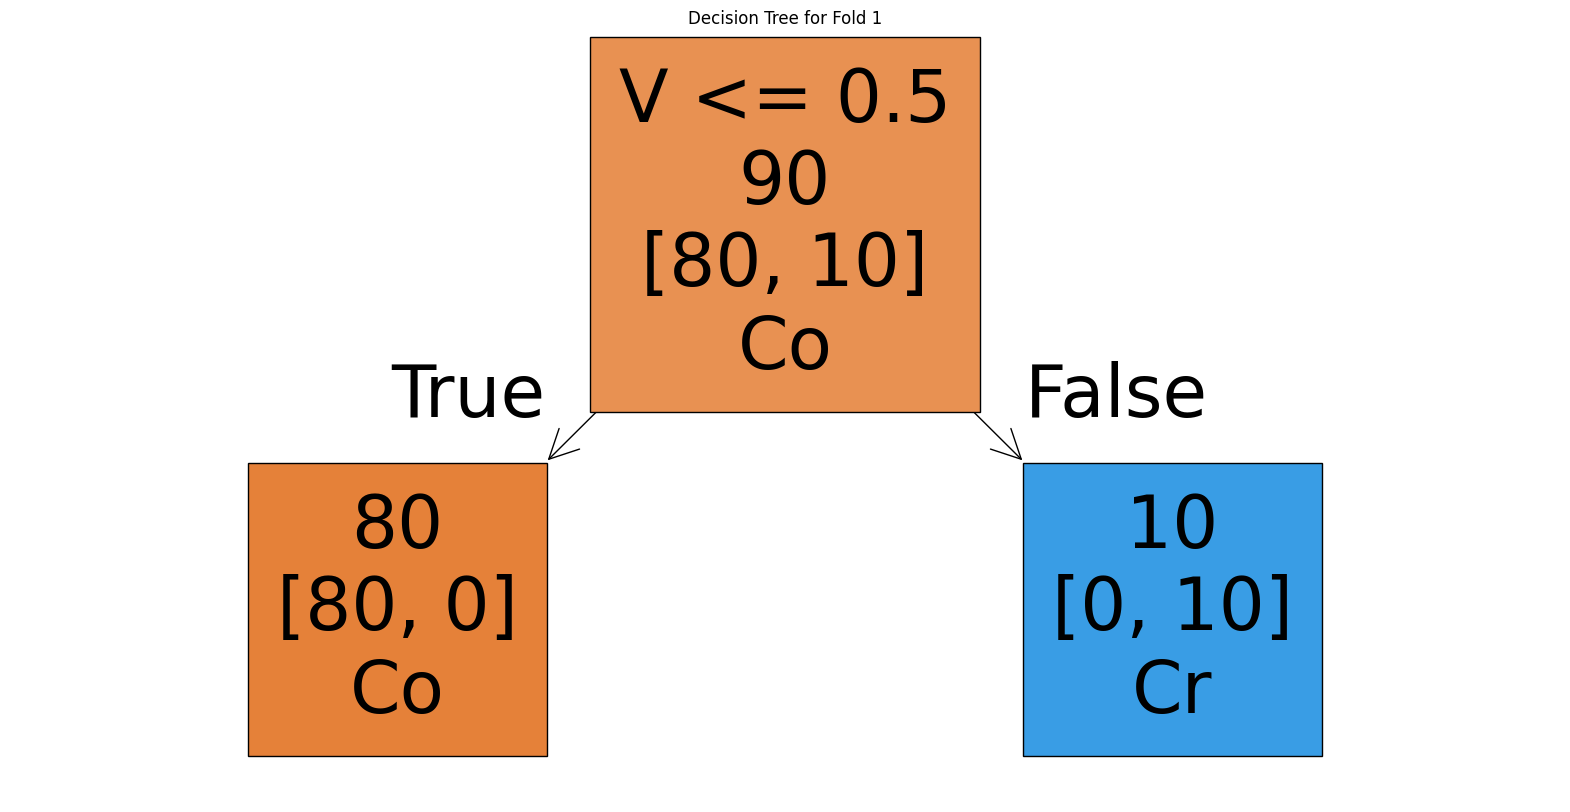

In [11]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import ClassifierChain
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and binary label columns (y)
X = df.copy()
y = df.copy()

# Initialize the base classifier
base_classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_train, titles_test = [titles[i] for i in train_index], [titles[i] for i in test_index]

    # Identify the columns (elements) that are present in the training data
    train_columns = X_train.columns[X_train.any() == 1]

    # Filter the test data to only include columns present in the training data
    X_train_filtered = X_train[train_columns]
    y_train_filtered = y_train[train_columns]
    X_test_filtered = X_test[train_columns]
    y_test_filtered = y_test[train_columns]

    # Initialize and train the classifier chain model with filtered data
    classifier_chain = ClassifierChain(base_classifier, order='random', random_state=42)
    classifier_chain.fit(X_train_filtered, y_train_filtered)

    # Predict on the filtered test set for this fold
    y_pred = classifier_chain.predict(X_test_filtered)

    # Print actual vs predicted compositions with titles for each object in the test set
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test_filtered.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report for this fold
    accuracy = accuracy_score(y_test_filtered, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test_filtered, y_pred, target_names=train_columns, zero_division=0))

    # Plot the decision tree without the value attribute
    plt.figure(figsize=(20, 10))
    plot_tree(
        classifier_chain.estimators_[0],  # Plot the first decision tree of the chain
        feature_names=X_train_filtered.columns,
        class_names=train_columns,
        filled=True,
        impurity=False,    # Remove impurity (like Gini or entropy)
        label='none'       # Remove 'value' and sample counts
    )
    plt.title(f"Decision Tree for Fold {fold-1}")
    plt.show()

    # Break after the first fold if you want to see just one tree
    break



============================== Fold 1 Results ==============================
Title | Actual | Predicted
paper-150 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-1 | Actual: Co, Cr, Fe, Mn, Cu, Si | Predicted: Co, Cr, Fe, Mn, Cu, Si
paper-110 | Actual: Al, Si, Mg | Predicted: Cr, V, Nb, Mo, Al
paper-131 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-133 | Actual: Co, Cr, Fe, Mn, Ni | Predicted: Co, Cr, Fe, Mn, Ni
paper-144 | Actual: Ti, Zr, Hf, Ta, Mo, N | Predicted: Ti, Zr, Hf, Ta, Mo
paper-210 | Actual: Nb, Ta, Mo, C, W | Predicted: Nb, Ta, Mo, C, W
paper-218 | Actual: Co, Cr, Fe, Ni, Al, Cu | Predicted: Co, Cr, Fe, Ni, Al, Cu
paper-229 | Actual: Ti, Zr, V, Nb, Al | Predicted: Ti, Zr, V, Nb, Al

Accuracy for Fold 1: 80.00%

Classification Report for Fold:
              precision    recall  f1-score   support

          Co       1.00      1.00      1.00         6
          Cr

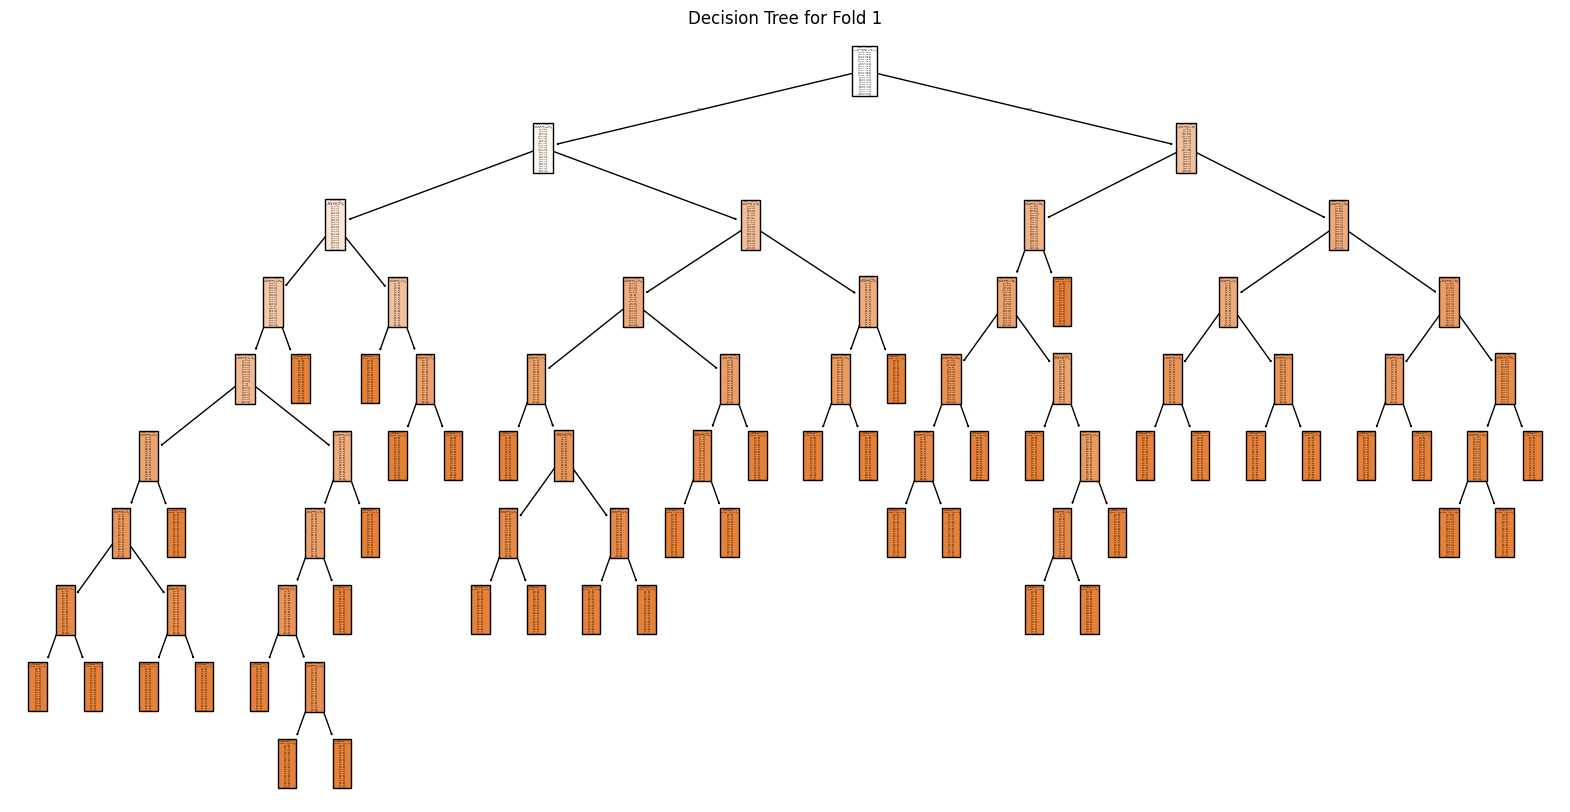

In [4]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
# Removed radioactive elements and noble gases.
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)  # Fill NaN with 0 for elements not present

# Define features (X) and labels (y)
X = df.copy()
y = df.copy()

# Initialize the decision tree classifier
classifier = DecisionTreeClassifier(random_state=42)

# Set up K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X):
    print(f"\n{'='*30} Fold {fold} Results {'='*30}")
    fold += 1

    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    titles_test = [titles[i] for i in test_index]

    # Train the single decision tree classifier
    classifier.fit(X_train, y_train)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Print actual vs predicted compositions with titles
    print("Title | Actual | Predicted")
    for title, actual, predicted in zip(titles_test, y_test.values, y_pred):
        actual_labels = ', '.join([col for col, val in zip(y.columns, actual) if val == 1])
        predicted_labels = ', '.join([col for col, val in zip(y.columns, predicted) if val == 1])
        print(f"{title} | Actual: {actual_labels} | Predicted: {predicted_labels}")

    # Calculate and print accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred) * 100
    print(f"\nAccuracy for Fold {fold-1}: {accuracy:.2f}%")

    print("\nClassification Report for Fold:")
    print(classification_report(y_test, y_pred, target_names=y.columns, zero_division=0))

    # Plot the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(classifier, feature_names=X.columns, class_names=y.columns, filled=True)
    plt.title(f"Decision Tree for Fold {fold-1}")
    plt.show()

    # Break after the first fold if you want to see just one tree
    break


[Text(0.5, 0.75, 'Co <= 0.5\n90\n[39, 51]\nCr'),
 Text(0.25, 0.25, '39\n[39, 0]\nCo'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, '51\n[0, 51]\nCr'),
 Text(0.625, 0.5, '  False')]

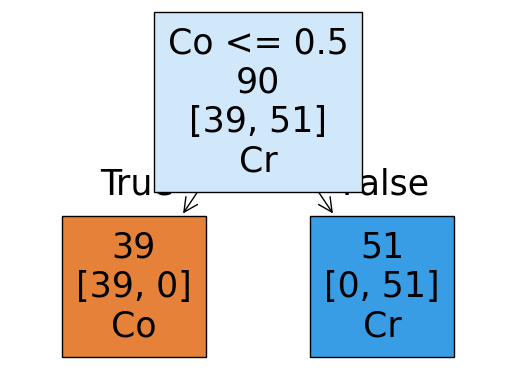

In [9]:
plot_tree(classifier, feature_names=X.columns, class_names=y.columns, filled=True, impurity=False, label='none')


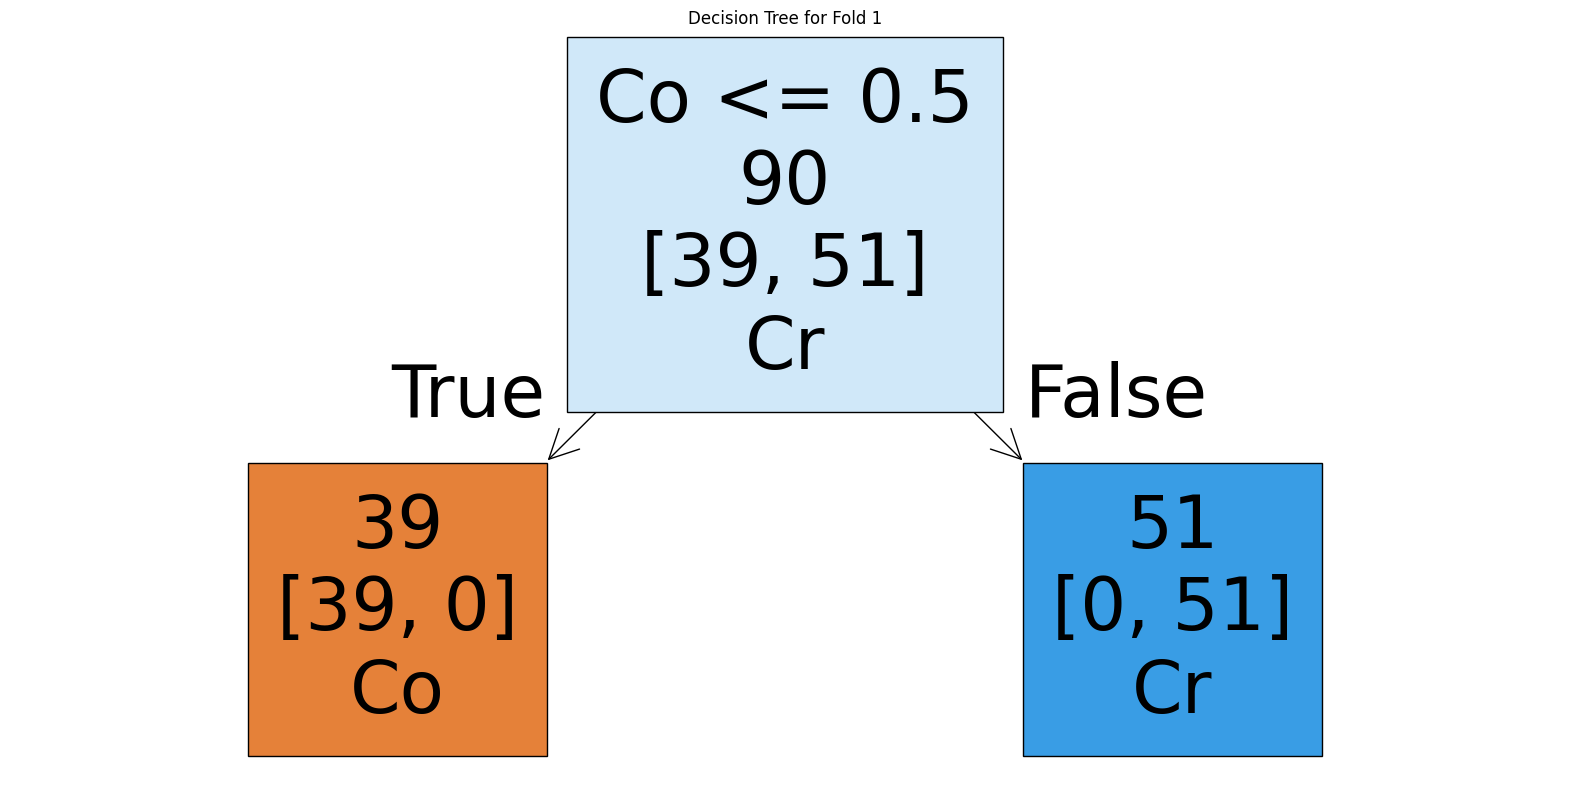

In [10]:
# Plot the decision tree without the value attribute
plt.figure(figsize=(20, 10))
plot_tree(
    classifier,
    feature_names=X.columns,
    class_names=y.columns,
    filled=True,
    impurity=False,    # Remove impurity (like Gini or entropy)
    label='none'       # Remove 'value' and sample counts
)
plt.title(f"Decision Tree for Fold {fold-1}")
plt.show()


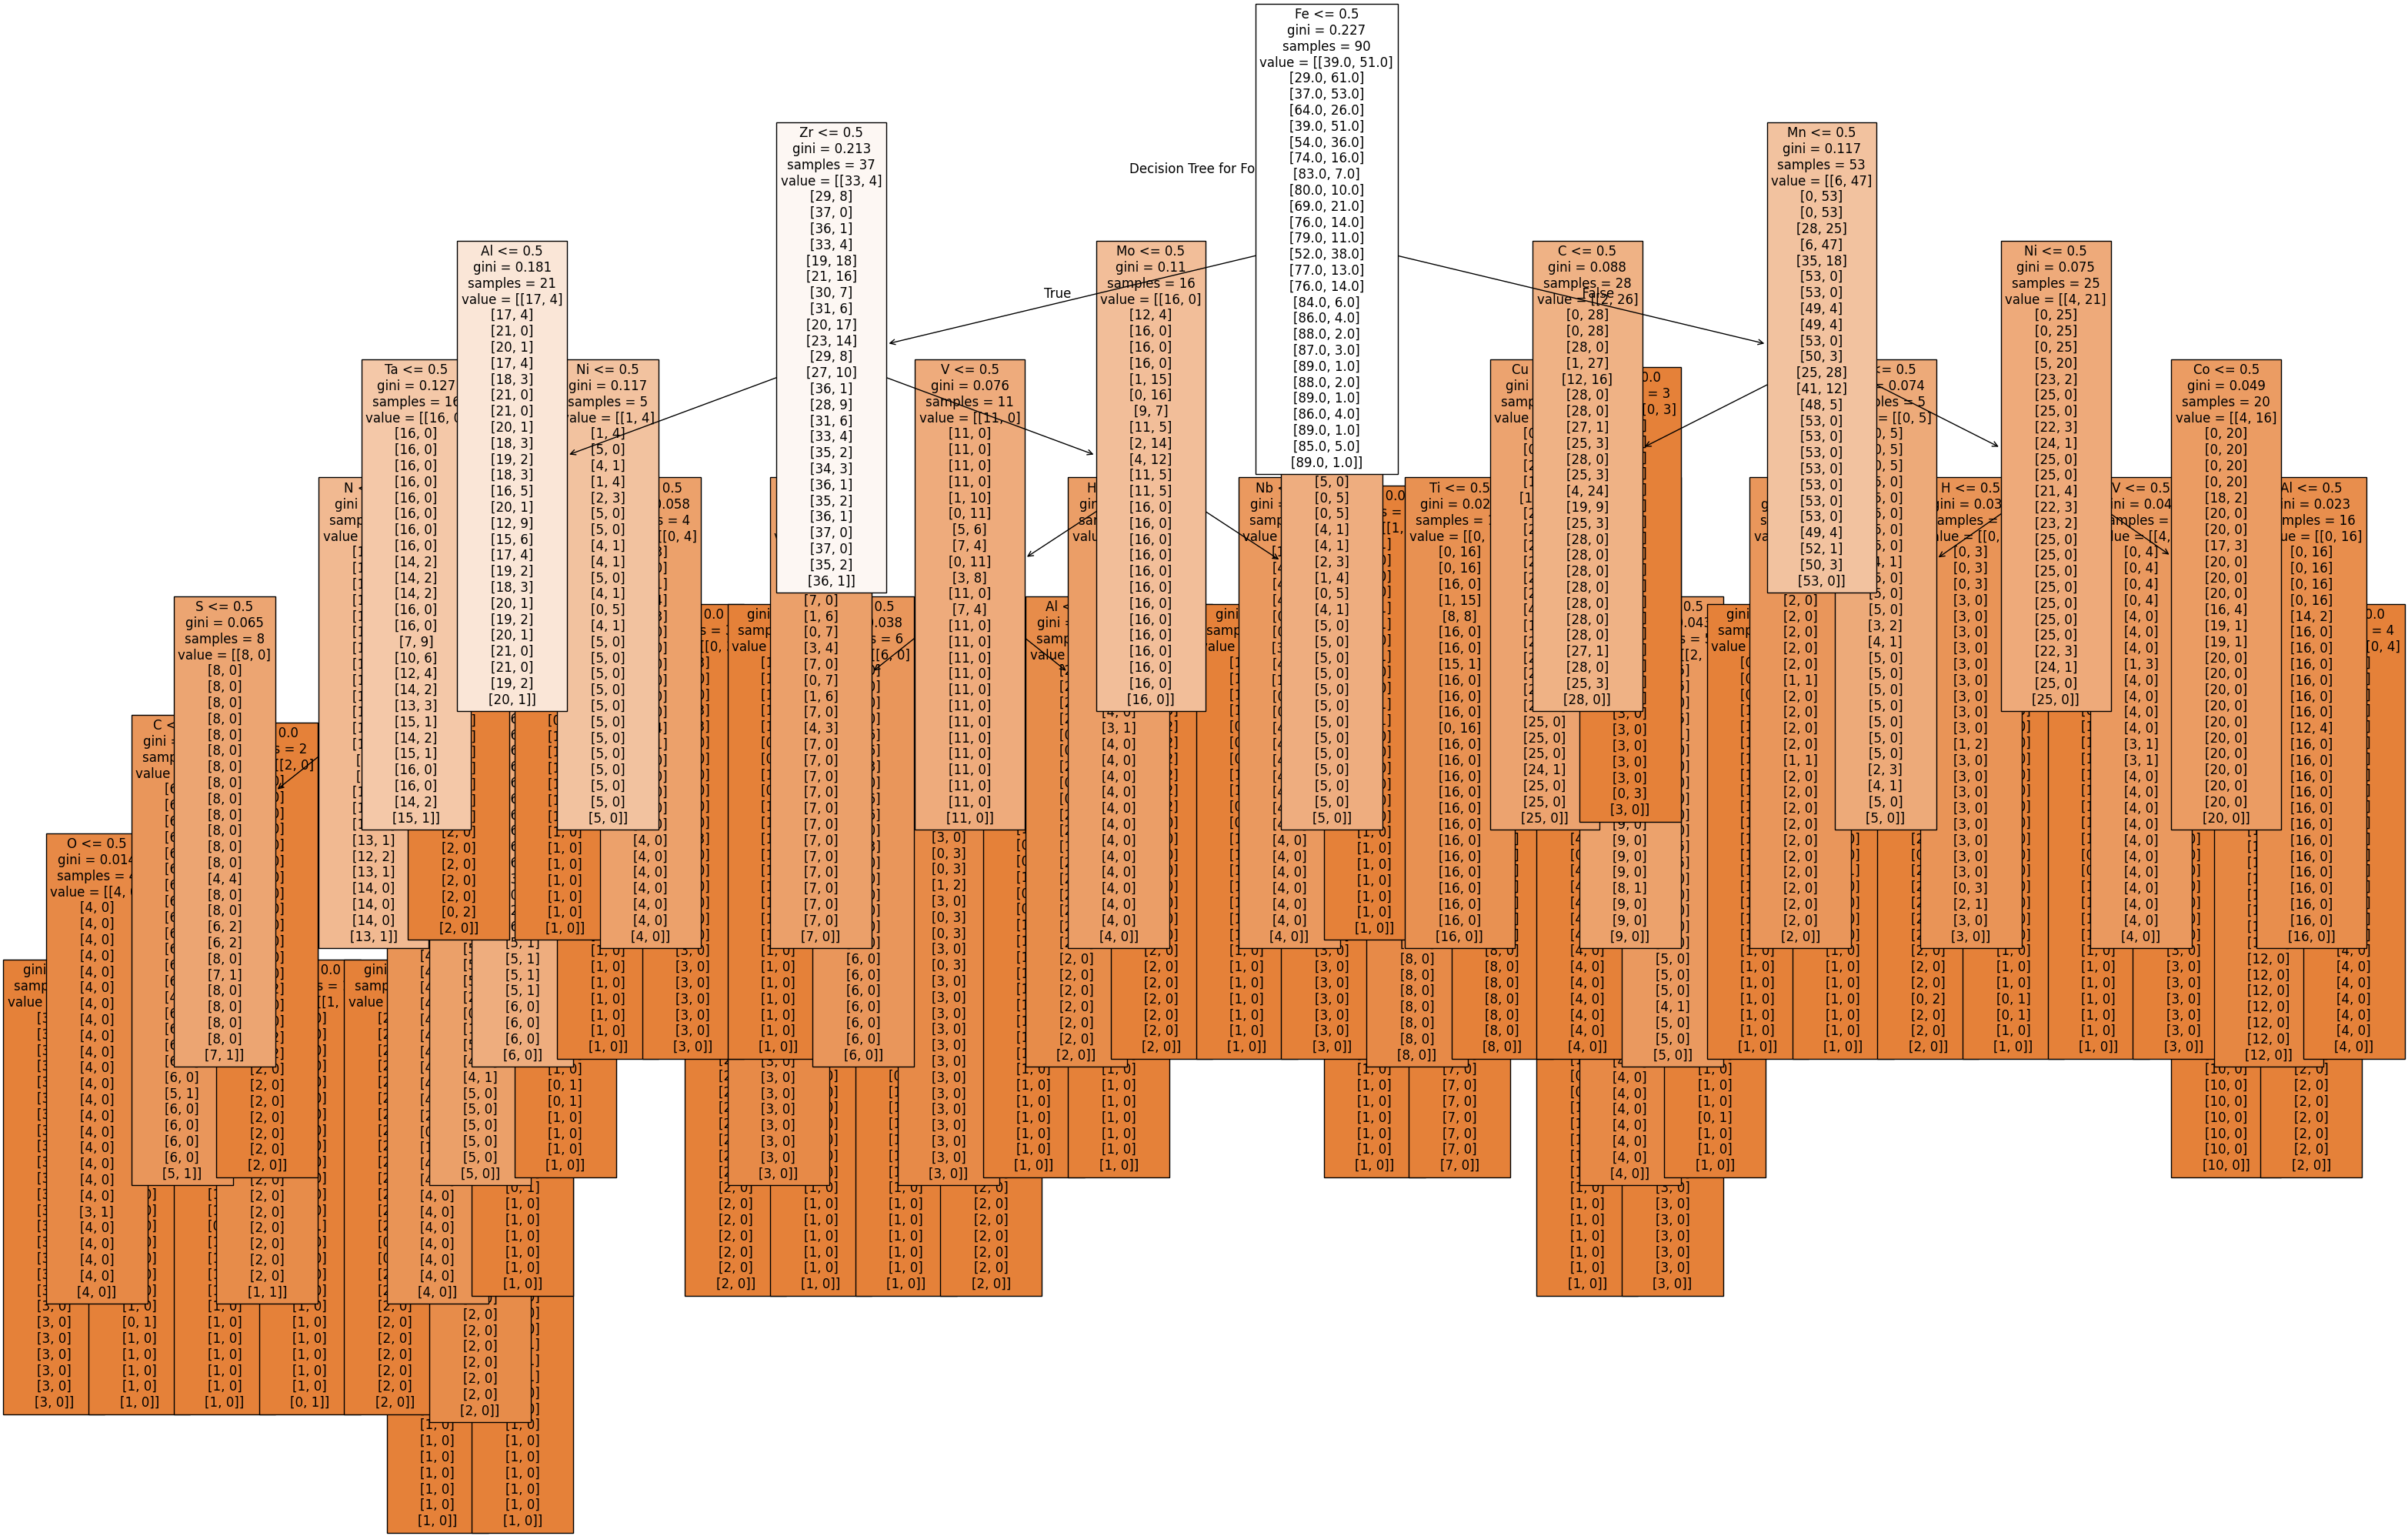

In [5]:
plt.figure(figsize=(40, 20))
plot_tree(classifier, feature_names=X.columns, class_names=y.columns, filled=True, fontsize=12)
plt.title(f"Decision Tree for Fold {fold-1}")
plt.savefig('decision_tree.png', dpi=300)  # Save the image in high resolution
plt.show()


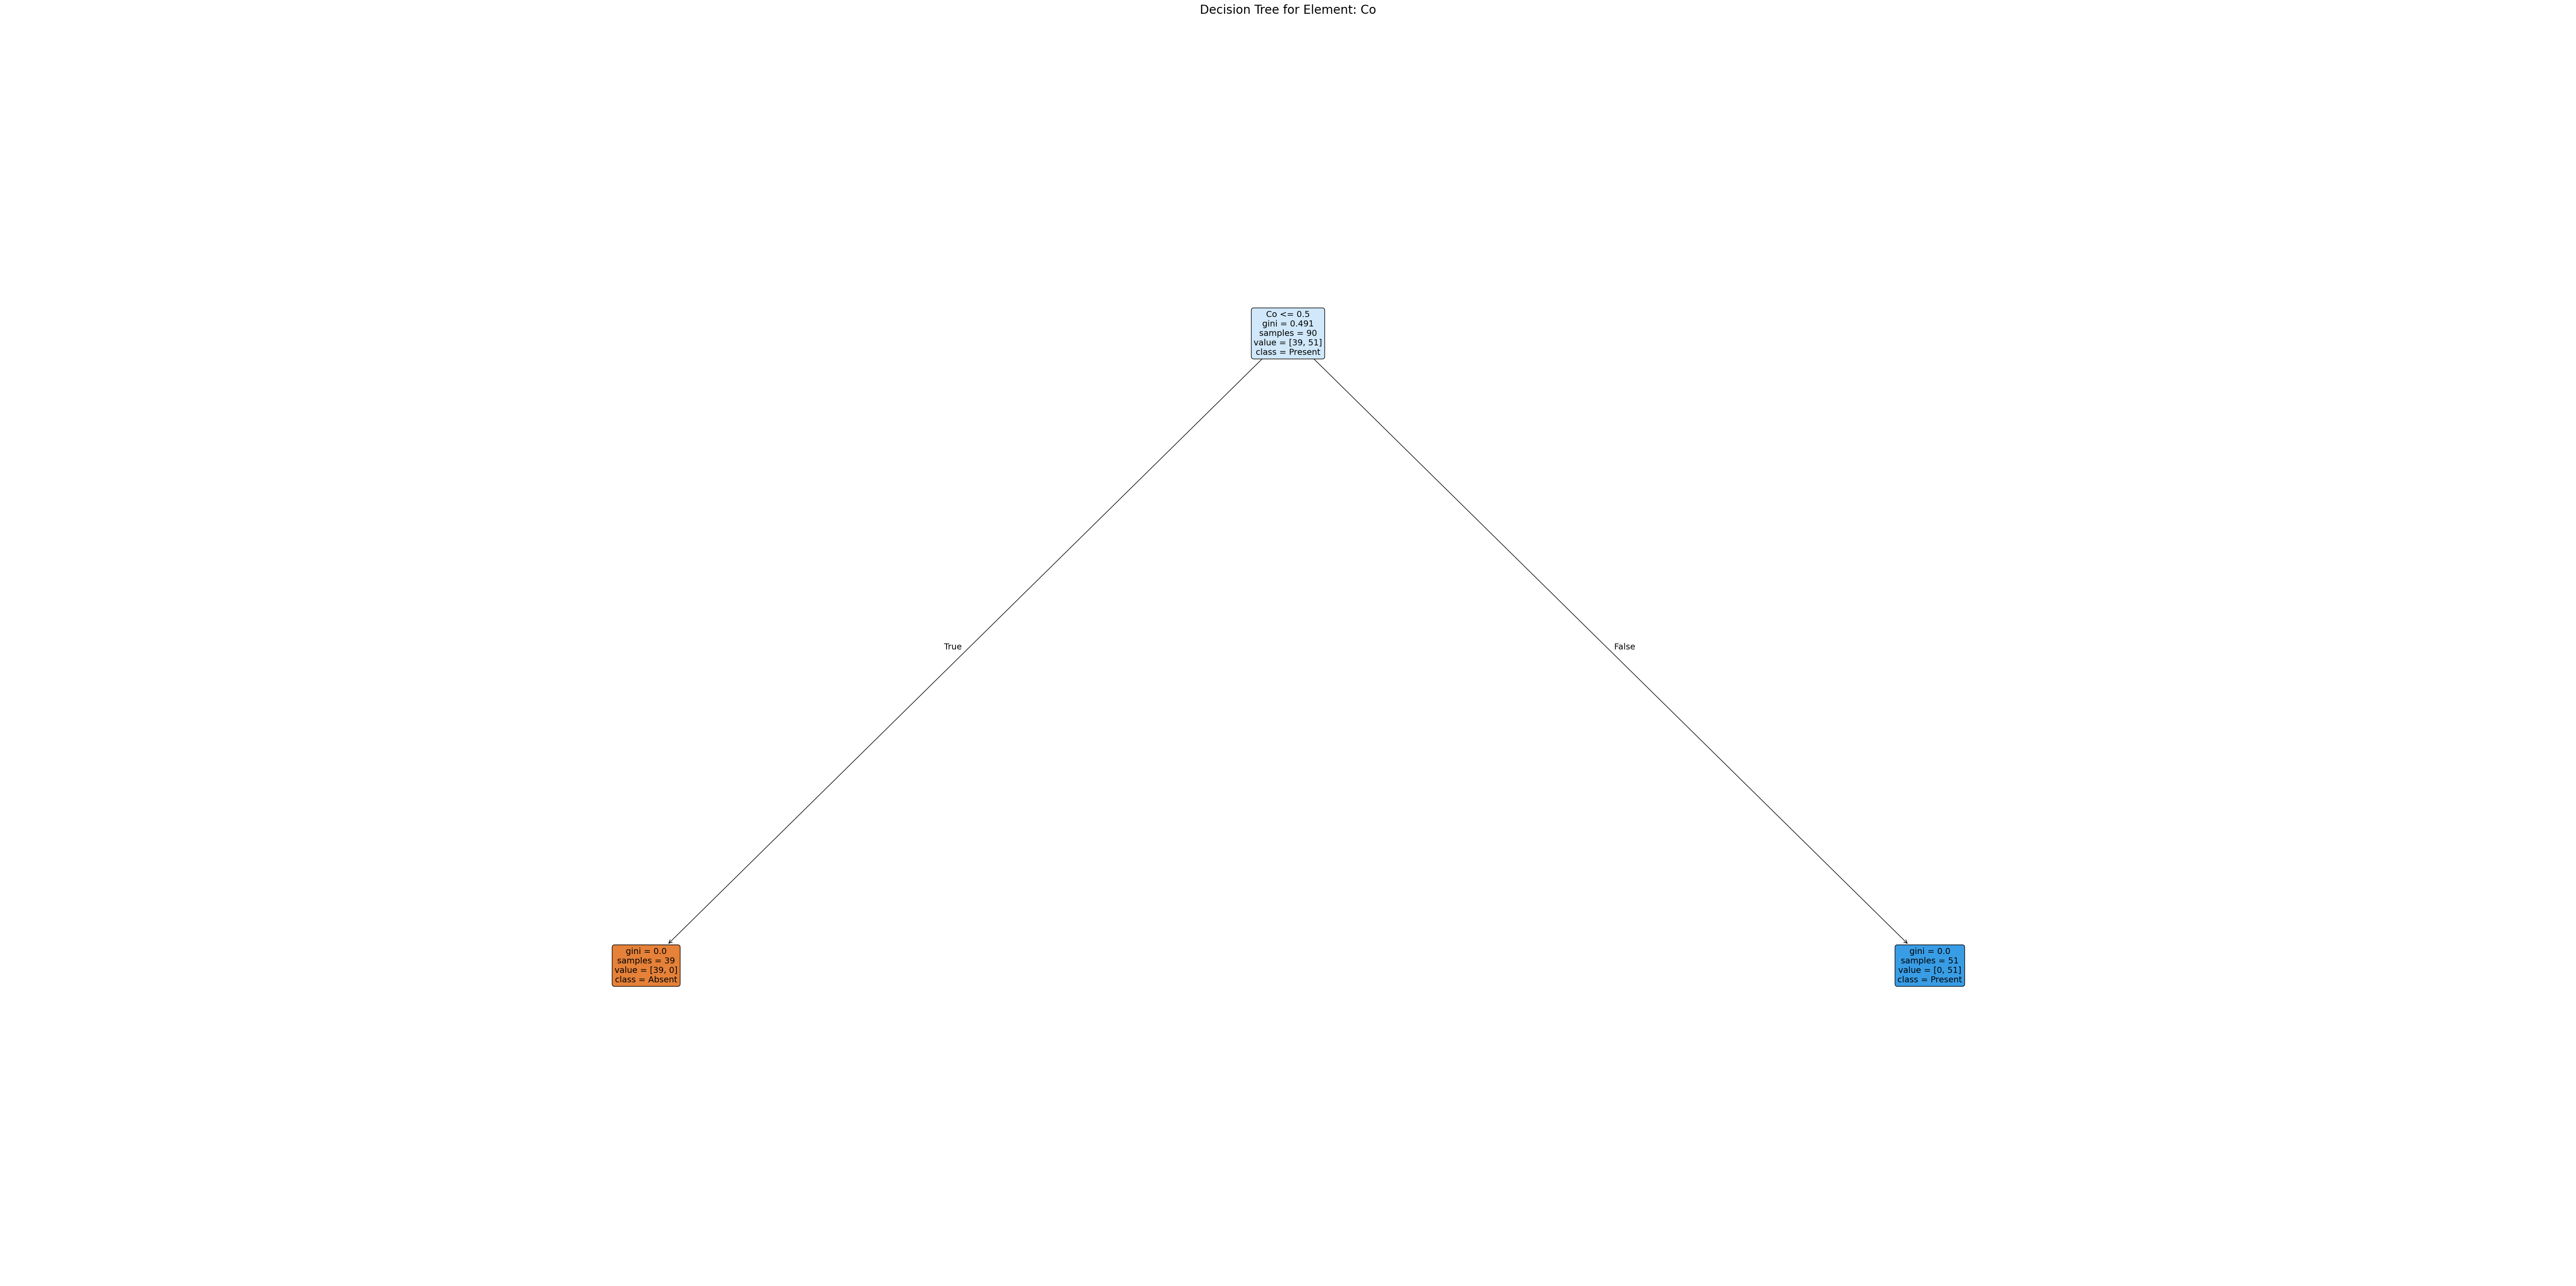

In [6]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)

# Features and labels (multi-label classification)
X = df.copy()
y = df.copy()

# Initialize Decision Tree Classifier with depth limit for better visualization
classifier = DecisionTreeClassifier(random_state=42, max_depth=3)

# Using first fold from K-Fold for training and visualization
kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_index, test_index = next(kf.split(X))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Training on the first element as a sample (to visualize a single tree)
element_to_visualize = y.columns[0]
classifier.fit(X_train, y_train[element_to_visualize])

# Plotting the decision tree
plt.figure(figsize=(60, 30))
plot_tree(classifier,
          feature_names=X.columns,
          class_names=['Absent', 'Present'],
          filled=True,
          fontsize=14,
          rounded=True)
plt.title(f"Decision Tree for Element: {element_to_visualize}", fontsize=20)
plt.tight_layout()
plt.savefig('decision_tree_visualization.svg', format='svg')  # Save as SVG for clarity
plt.show()


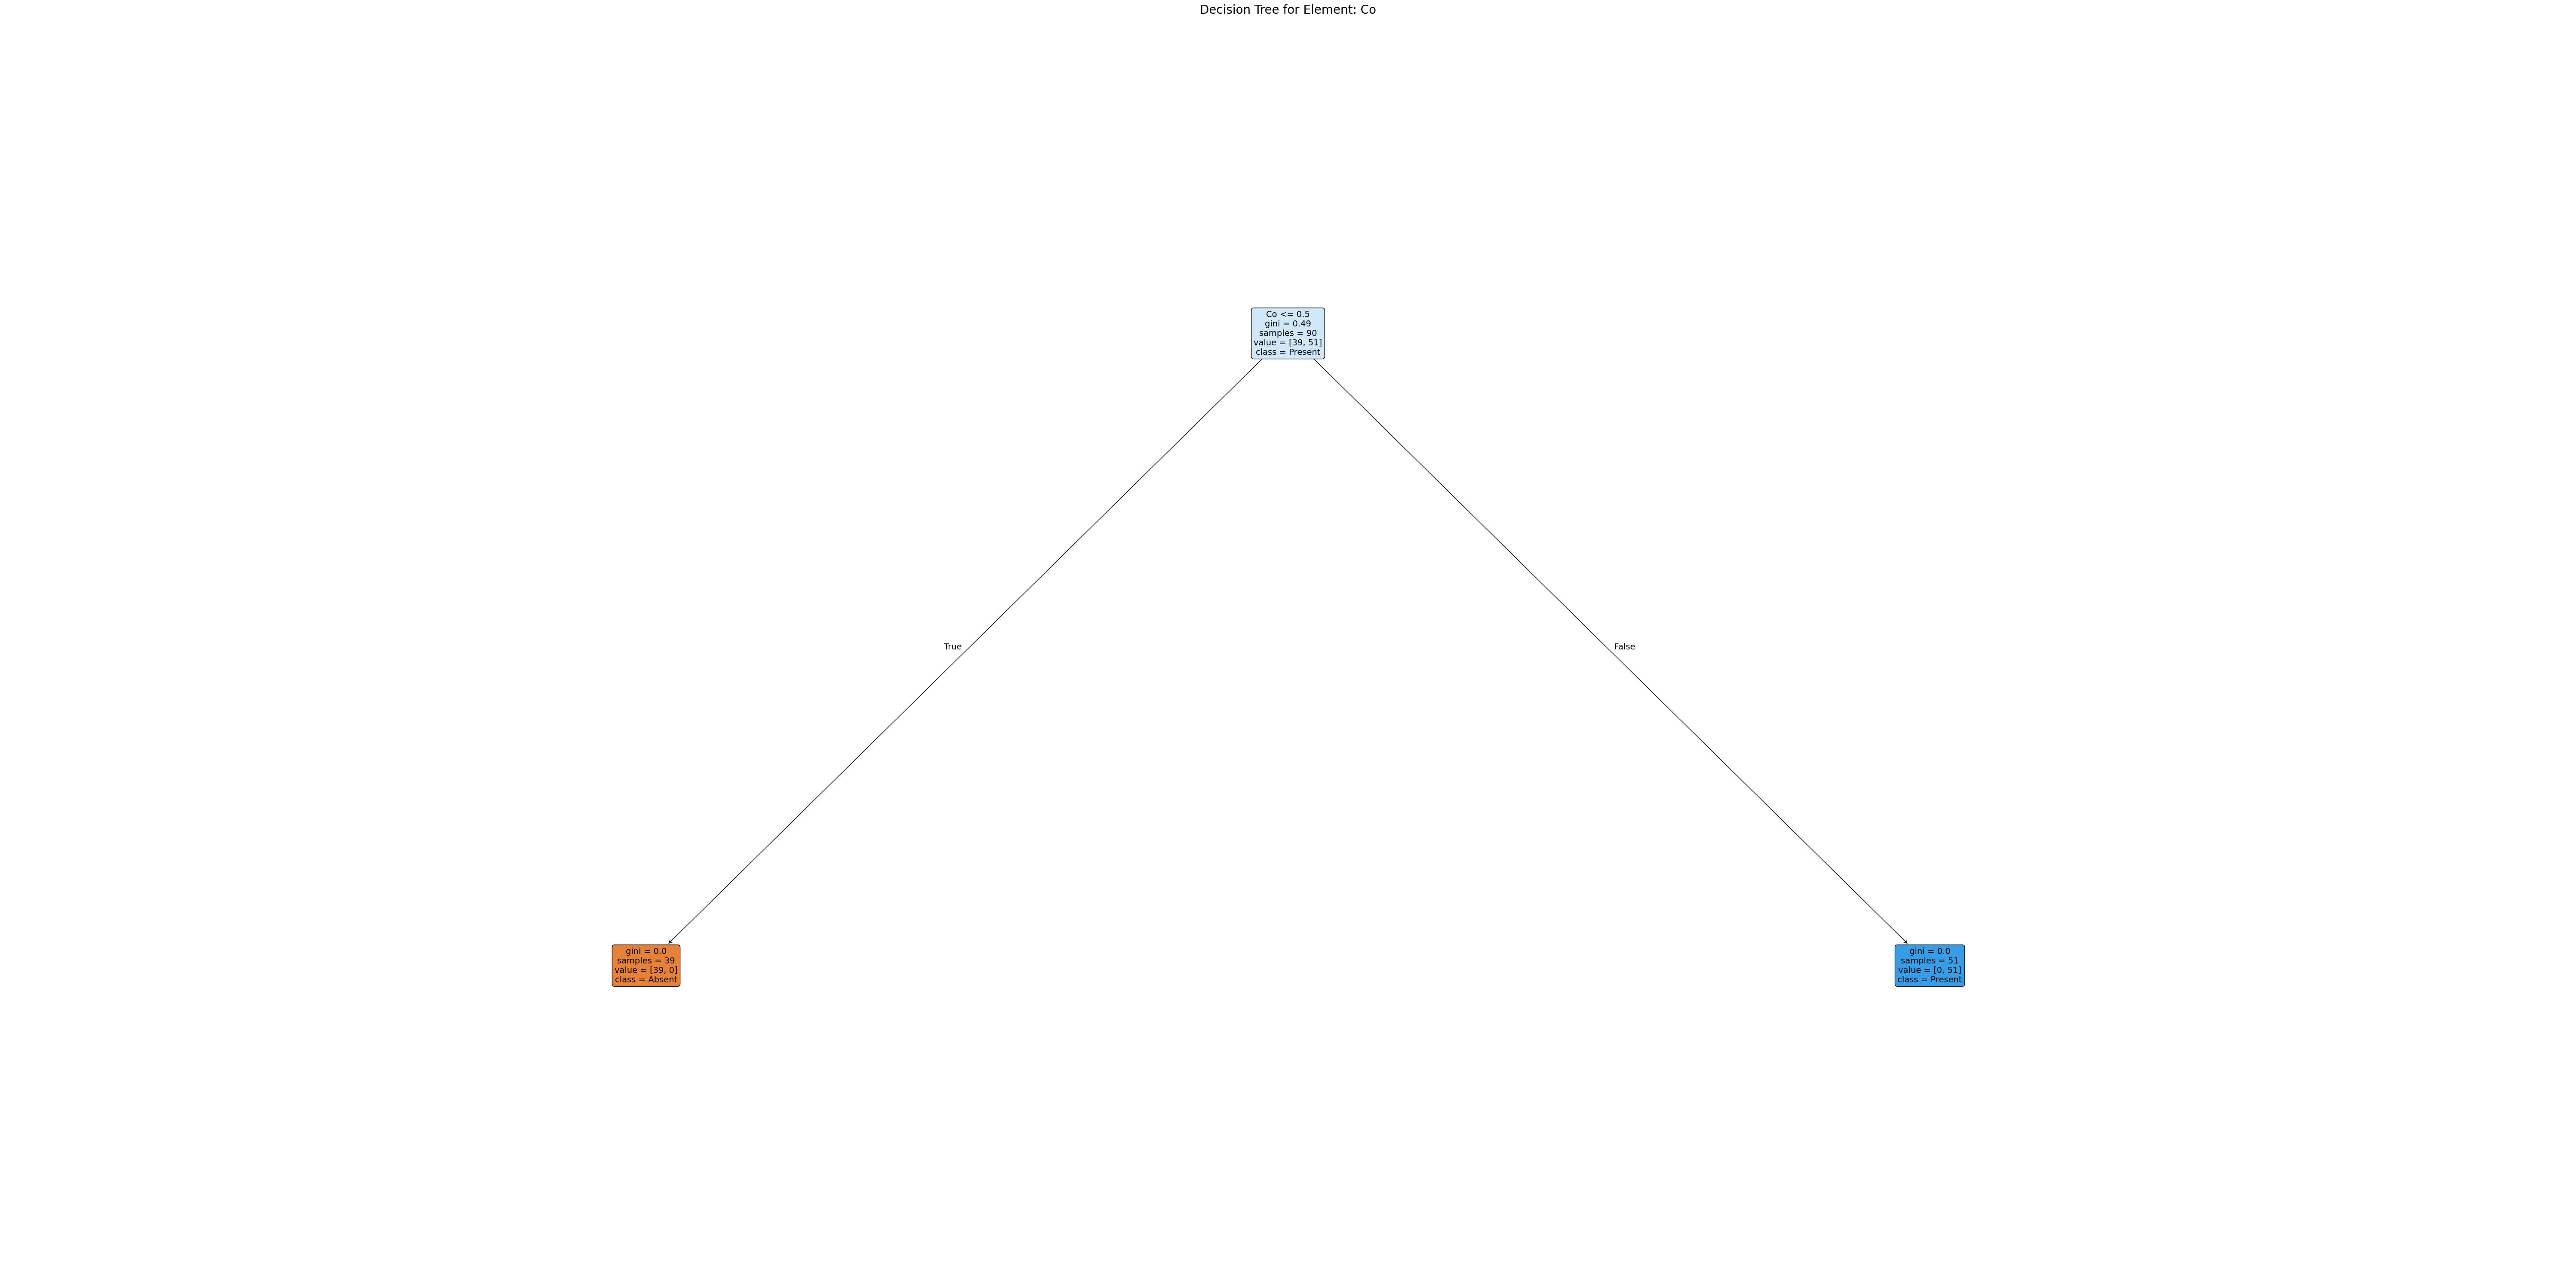

In [7]:
import json
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# List of valid chemical elements (symbols) in the periodic table
periodic_elements = {
    "H", "Li", "Be", "B", "C", "N", "O", "F", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "K", "Ca",
    "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Rb", "Sr", "Y",
    "Zr", "Nb", "Mo", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Sb", "Te", "I", "Cs", "Ba", "La", "Ce", "Pr",
    "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt",
    "Au", "Hg", "Tl", "Pb", "Bi"
}

# Load the data
with open('admin.materials_100.json') as f:
    data = json.load(f)

# Extracting composition data and converting to DataFrame
compositions = []
titles = []

for entry in data:
    if not entry.get('composition'):
        continue
    composition = {element: 1 for element in entry['composition'].keys() if element in periodic_elements}
    titles.append(entry['title'])
    compositions.append(composition)

# Convert compositions to DataFrame
df = pd.DataFrame(compositions)
df.fillna(0, inplace=True)

# Features and labels (multi-label classification)
X = df.copy()
y = df.copy()

# Initialize Decision Tree Classifier with depth limit for better visualization
classifier = DecisionTreeClassifier(random_state=42, max_depth=3)

# Using first fold from K-Fold for training and visualization
kf = KFold(n_splits=10, shuffle=True, random_state=42)
train_index, test_index = next(kf.split(X))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Training on the first element as a sample (to visualize a single tree)
element_to_visualize = y.columns[0]
classifier.fit(X_train, y_train[element_to_visualize])

# Plotting the decision tree with values
plt.figure(figsize=(60, 30))
plot_tree(classifier,
          feature_names=X.columns,
          class_names=['Absent', 'Present'],
          filled=True,
          fontsize=14,
          rounded=True,
          proportion=False,  # Show raw counts instead of proportions
          precision=2)       # Display numbers with 2 decimal precision

plt.title(f"Decision Tree for Element: {element_to_visualize}", fontsize=20)
plt.tight_layout()
plt.savefig('decision_tree_with_values.svg', format='svg')  # Save as SVG for better clarity
plt.show()


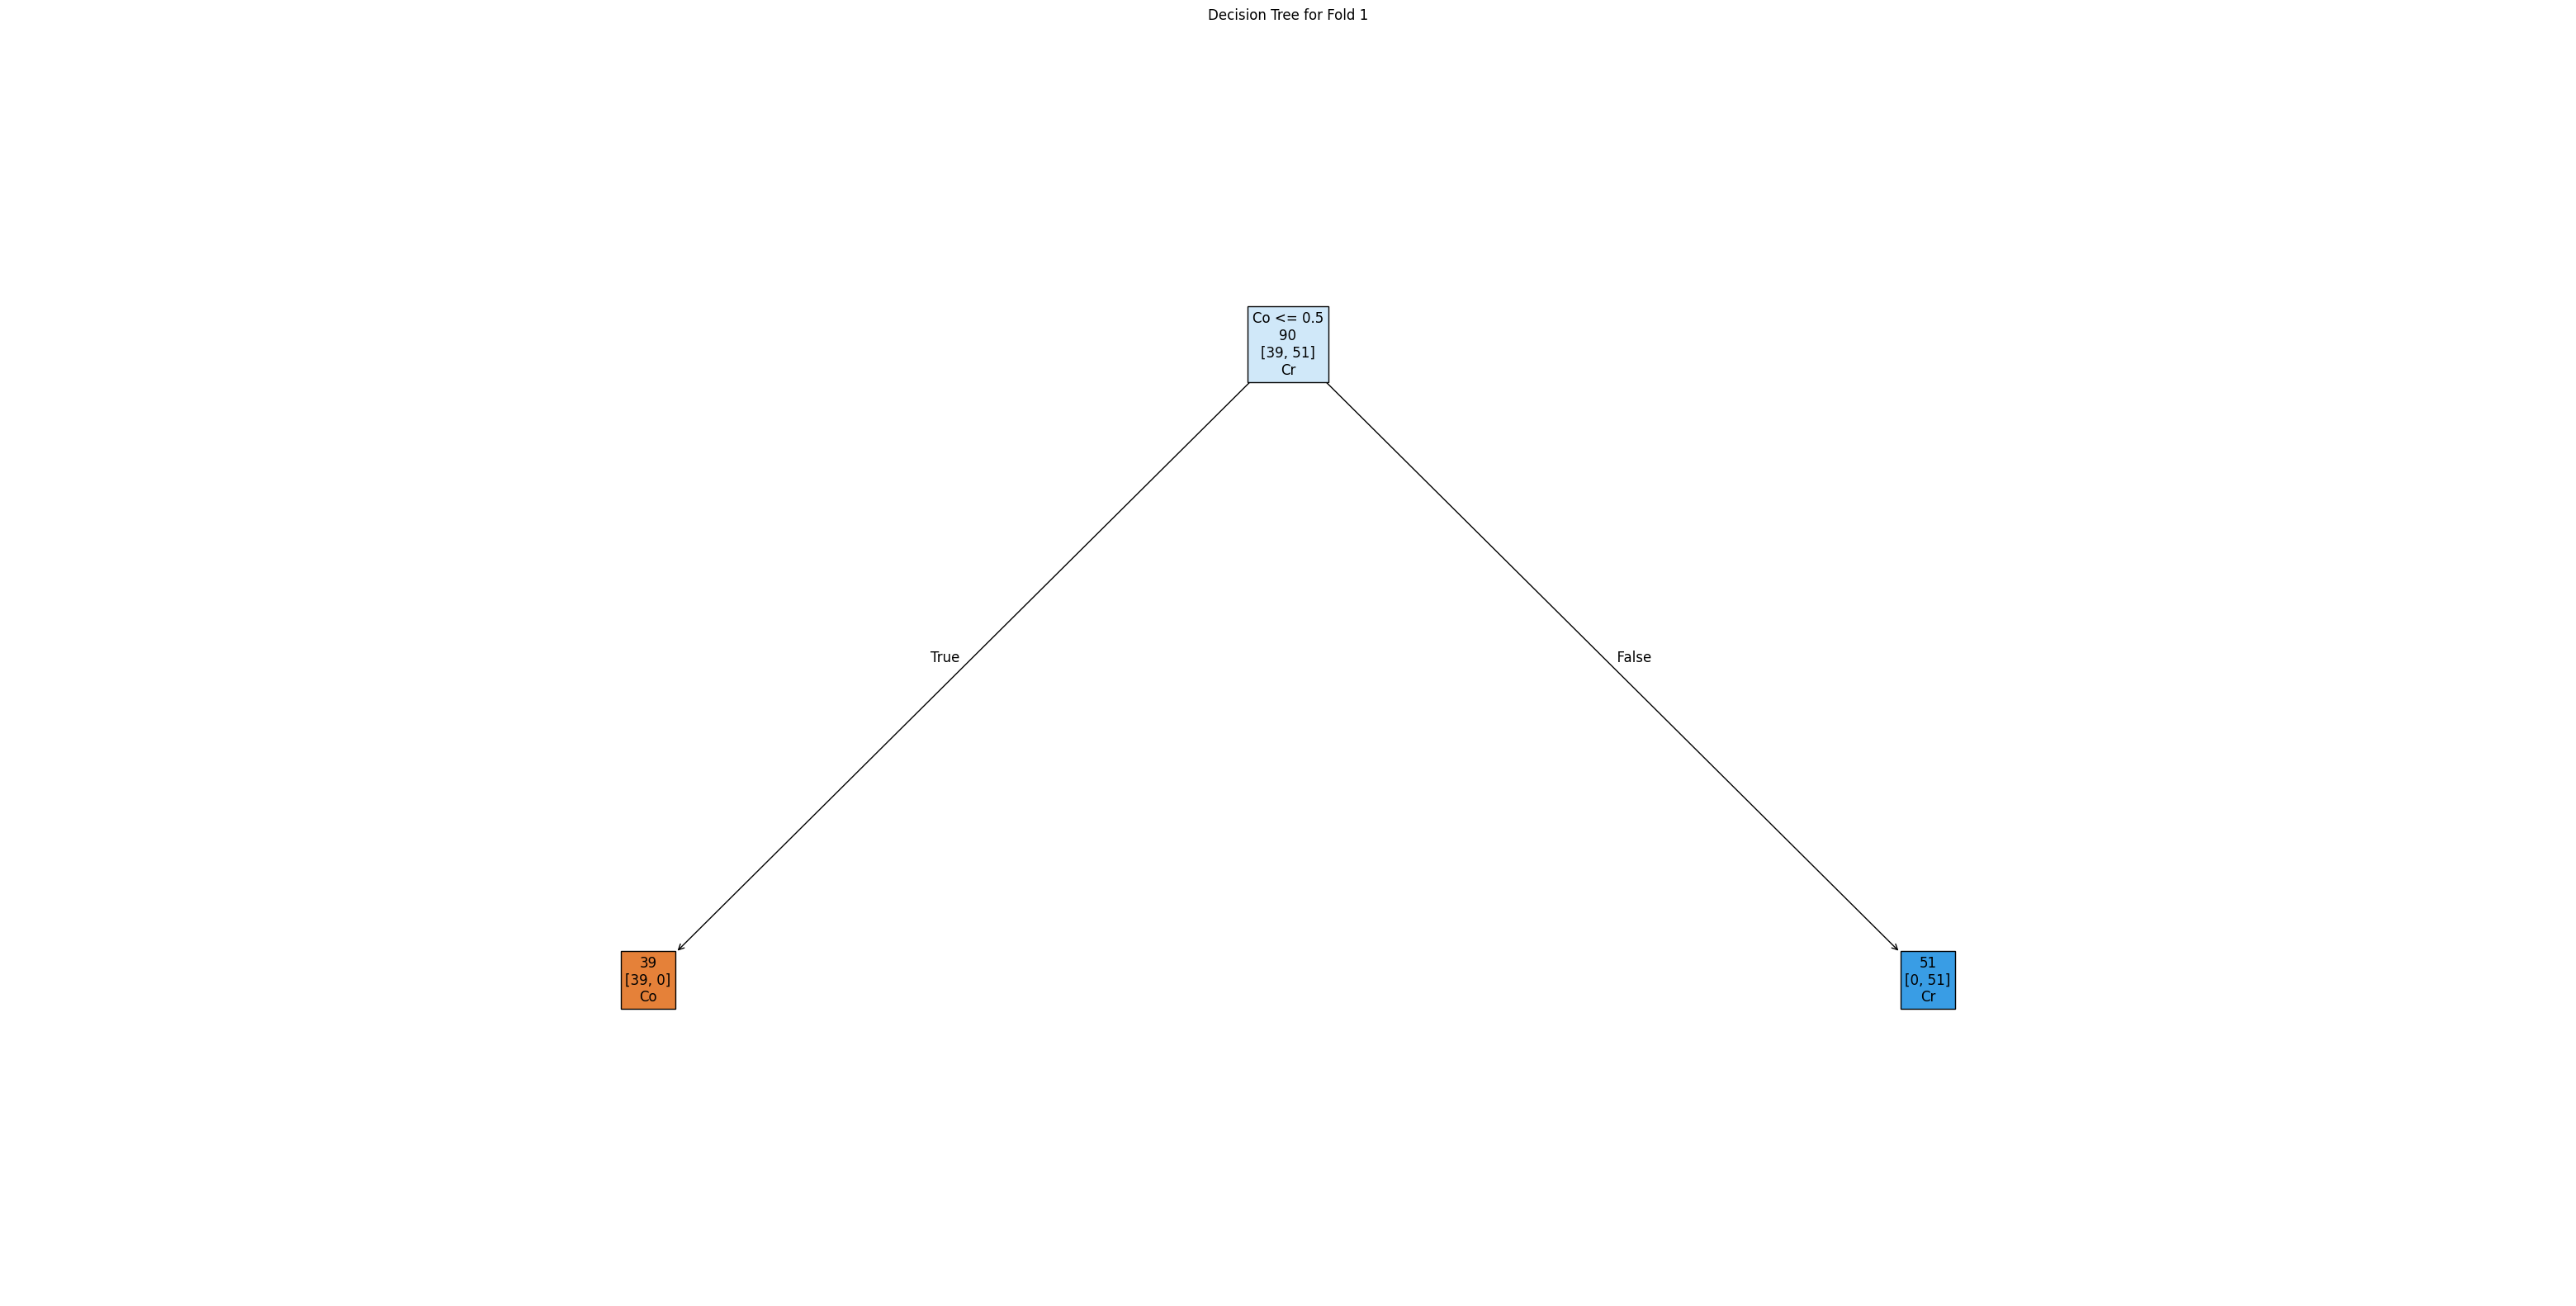

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plotting the decision tree without node values
plt.figure(figsize=(40, 20))
plot_tree(classifier,
          feature_names=X.columns,   # Display feature names
          class_names=y.columns,     # Display class names
          filled=True,               # Fill nodes with color
          fontsize=12,               # Font size for readability
          impurity=False,            # Remove Gini impurity values
          proportion=False,          # No proportion values
          label='none')              # Remove class and sample counts

plt.title(f"Decision Tree for Fold {fold-1}")
plt.savefig('decision_tree.png', dpi=300)  # Save the image in high resolution
plt.show()
